# Context Engineering

Context Engineering relies on two core systems:

1. Sessions: The container for a single, continuous conversation, holding the chronological history of the dialogue (events) and the agent's working memory (state). Sessions govern the immediate state of the conversation. To combat the challenges of increasing cost and "context rot" in long conversations, Context Engineering employs compaction strategies like truncation or recursive summarization to preserve vital information while managing the overall token count within the session history.

2. Memory: The mechanism for long-term persistence, capturing and consolidating key information across multiple sessions to provide a continuous, personalized experience. While Retrieval-Augmented Generation (RAG) makes an agent an expert on static facts, Memory serves to make the agent an expert on the user.

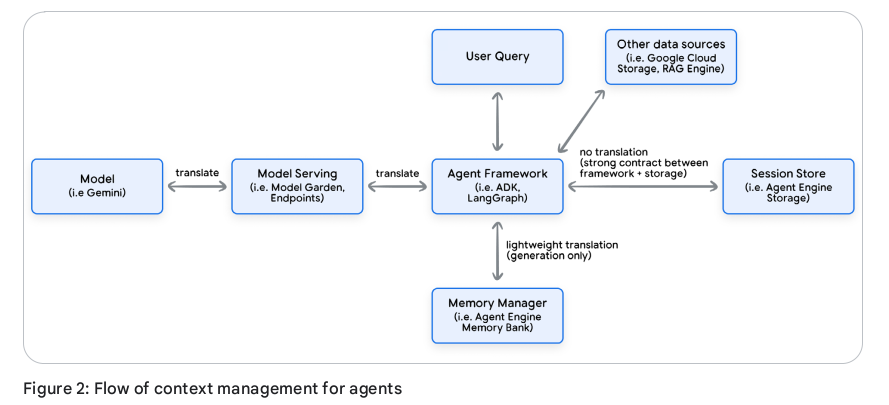

## Sessions

Every session contains two primary components: the chronological history and the agent's working memory.

1. **Events** (Chronological History): Events are the building blocks of the conversation, forming the turn-by-turn record of the current interaction. Common types of events include user input (e.g., text, audio, image), the agent response, a tool call (the agent’s decision to use an external function), and tool output (the data returned from that call). As the conversation progresses, the agent appends additional events to the session.

2. **State** (Working Memory): The session often includes a structured "working memory" or scratchpad. This component holds temporary, structured data relevant only to the current conversation, such as what items might be listed in a shopping cart. The agent may mutate the state based on the logic applied during the interaction.

### Managing Long Conversations and Compaction

A critical challenge for agents is managing an ever-growing session history. As the context grows, models can suffer from "context rot," where their ability to pay attention to crucial information diminishes. Furthermore, a growing context increases API costs and latency, slowing down the user experience.

To address these challenges, Context Engineering employs compaction strategies that dynamically mutate the history to preserve vital information while managing the overall token count. Strategies for shrinking long conversation histories include:

• **Keep the last N turns**: This simple "sliding window" strategy discards everything older than a predefined number of recent turns.

• **Token-Based Truncation**: The agent counts tokens, starting from the most recent messages, and includes as many messages as possible without exceeding a set token limit.

• **Recursive Summarization**: Older parts of the conversation are replaced by an LLM-generated summary, which acts as a condensed form of the history and is often prefixed to the more recent, verbatim messages.

Compaction decisions are often triggered by count-based thresholds (like token size or turn count), time-based inactivity, or event-based triggers that detect the conclusion of a topic or task. Expensive compaction operations, such as recursive summarization, should be executed asynchronously in the background and the results persisted to storage to ensure the client is not kept waiting.

### Production and Storage Considerations

For production agents, which are typically stateless, the session history must be saved to persistent storage (robust databases) to maintain a continuous user experience. Key production considerations include:

• **Performance and Scalability**: Session data is on the "hot path" of every user interaction, so reading and writing the history must be extremely fast to ensure a responsive experience. Latency can be mitigated by filtering or compacting the session history before it is transferred to the agent.

• **Security and Privacy**: Strict isolation must be enforced, meaning a session is owned by a single user and one user can never access another's session data. A best practice is to redact Personally Identifiable Information (PII) before the session data is written to storage, simplifying compliance with privacy regulations.

• **Data Integrity**: The system must guarantee that events are appended to the session history in a deterministic, chronological order, which is fundamental to the integrity of the conversation log. A Time-to-Live (TTL) policy can be implemented to automatically delete inactive sessions.

### Sessions in Multi-Agent Systems

In systems where multiple agents collaborate, the architecture defines how they share information, particularly the session history (the permanent, unabridged transcript). 
Frameworks typically manage this history in one of two ways:

1. **Shared, Unified History**: All agents contribute and read all events from a single, central conversation log in chronological order. This is suitable for tightly coupled, collaborative tasks requiring a single source of truth.

2. **Separate, Individual Histories**: Each agent maintains its own private conversation log, keeping internal processes (like reasoning steps and tool use) hidden. Communication only occurs through explicit messages containing final output.

The session can be thought of as the **workbench** for a specific project, covered in immediately accessible but temporary tools, notes, and materials relevant only to the task at hand.

## Memory

Memory for an agent is categorized based on how the information is stored and captured, working together to create a rich, contextual understanding of the user and their needs. Memories are defined as extracted information, not the raw dialogue of the turn-by-turn conversation. Across all categories, the rule stands that memories are descriptive, not predictive.
Memory types can be detailed by the kind of knowledge they represent, how they are organized, the architecture used for storage, and the mechanism by which they were created.

### Types of Knowledge (Functional Categories)

Memories are classified into two primary functional categories, derived from cognitive science, based on the fundamental type of knowledge they represent:
• **Declarative Memory (“Knowing What”)**: This is the agent's knowledge of facts, figures, and events—all the information the agent can explicitly state or "declare". If a memory answers a "what" question, it is declarative. This type encompasses both general world knowledge (Semantic) and specific user facts (Entity/Episodic). Most commercial memory management platforms are architected for this approach, excelling at retrieving the "what"—facts, history, and user data.

• **Procedural Memory (“Knowing How”)**: This is the agent's knowledge of skills and workflows, guiding the agent's actions by implicitly demonstrating how to perform a task correctly. If a memory helps answer a "how" question—such as the correct sequence of tool calls to book a trip—it is procedural. Procedural memories are used to improve an agent's reasoning and workflows and are generally intended to help with the agent’s reasoning for all users.

### Organization Patterns
Memory managers typically use one or more patterns to organize memories, defining how individual memories relate to each other and to the user:

• **Collections**: This pattern organizes content into multiple self-contained, natural language memories for a single user. Each memory is a distinct event, summary, or observation, allowing for storage and searching through a larger, less structured pool of information related to specific goals or topics.

• **Structured User Profile**: Memories are organized as a set of core facts about a user, like a continuously updated contact card. This pattern is designed for quick lookups of essential, factual information such as names, preferences, and account details.

• **Rolling Summary**: This pattern consolidates all information into a single, evolving memory that represents a natural-language summary of the entire user-agent relationship. Instead of creating new, individual memories, the memory manager continuously updates this one master document. This pattern is often used to compact long sessions, preserving vital information while managing the overall token count.

### Creation Mechanisms

Memories can also be categorized based on how they were derived and generated:

• **Explicit Memories**: These are created when the user gives a direct command to the agent to remember something (e.g., "Remember my anniversary is October 26th").

• **Implicit Memories**: These are created when the agent infers and extracts information from the conversation without a direct command (e.g., extracting a detail like "My anniversary is next week" from a request for gift ideas).

• **Internal Memory**: Refers to memory management logic that is built directly into the agent framework. While convenient, it often lacks advanced features.

• **External Memory**: Involves using a separate, specialized service (like Agent Engine Memory Bank) dedicated to memory management. This approach provides more sophisticated features such as semantic search, entity extraction, and automatic summarization.

### Storage Architectures

The choice of storage architecture determines how quickly and intelligently an agent can retrieve memories. Memories are generally stored in one of two ways, or a combination of both:

• **Vector Databases**: The most common approach, where memories are converted into embedding vectors. This enables retrieval based on semantic similarity (conceptual relation) rather than exact keywords and excels at retrieving unstructured, natural language memories.

• **Knowledge Graphs**: Stores memories as a network of entities (nodes) and their relationships (edges). Retrieval involves traversing the graph to find direct and indirect connections, which is ideal for structured, relational queries and understanding complex connections.

### Multimodal Capabilities

Memory can also be classified by how it handles non-textual information, distinguishing between the source data and the memory's content:

• **Memory from a Multimodal Source**: The agent processes various data types (text, images, audio), but the memory it creates is a textual insight derived from that source. For instance, it transcribes a user's voice memo and creates a textual memory, rather than storing the audio file itself.

• **Memory with Multimodal Content**: A more advanced approach where the memory itself contains non-textual media, such as storing an image file directly alongside the user's request. Most contemporary memory managers focus on handling multimodal sources while producing textual content, as converting all inputs into a common, searchable text format is simpler.

Memory acts as the agent's personal assistant, carrying a private, highly isolated notebook that records personal preferences and evolving goals, contrasting with Retrieval-Augmented Generation (RAG), which functions as a research librarian providing access to static, shared, factual knowledge about the world.

### Memory Consolidation

Memory consolidation is the most sophisticated stage in the memory lifecycle, where newly extracted information is integrated into the agent's existing knowledge base to maintain coherence, accuracy, and evolution. This process is crucial because without it, an agent's memory would quickly become contradictory and unreliable.

Consolidation is an LLM-driven workflow that functions as a "self-curation" process:

1. **Retrieve Candidates**: The workflow first retrieves existing memories that are similar to the newly extracted insights.

2. **Analyze and Decide**: An LLM analyzes the existing memories and the new information to identify necessary operations.

3. **Perform Operations**: The memory manager performs operations such as UPDATE (modify existing memory), CREATE (if the insight is novel), or DELETE/INVALIDATE (if the old memory is now irrelevant or incorrect).

This process addresses common problems in conversational data, including information duplication, conflicting facts, information evolution (nuancing a fact over time), and memory relevance decay (pruning old or stale memories). The agent must proactively manage "forgetting" by instructing the LLM to defer to newer information or through automatic Time-to-Live (TTL) deletion.
The result of consolidation is a curated understanding of the user, transforming a simple collection of facts into a reliable knowledge base

### Memory Provenance

Memory Provenance is the detailed record of a memory's origin and history, which is essential for determining its trustworthiness and quality. For an agent to make reliable decisions and for the memory manager to consolidate memories effectively, it must be able to critically evaluate the quality of its knowledge, and this trustworthiness is derived directly from provenance.

Key details that must be tracked to assess a memory's trustworthiness include its origin (source type) and age ("freshness"). Provenance is critical for two reasons:
1. **Memory Management**: It dictates the weight each source has during memory consolidation, especially when resolving conflicts between different data sources.

2. **Inference**: It informs how much the agent should rely on that memory during inference.

Data sources contributing to memory provenance generally fall into three categories:

• **Bootstrapped Data**: High-trust information pre-loaded from internal systems (e.g., a CRM), often used to solve the cold-start problem.

• **User Input**: Data provided explicitly (high-trust, via a form) or extracted implicitly from a conversation (generally less trustworthy).

• **Tool Output**: Data returned from external tool calls, which is generally discouraged for memory generation because it can be brittle and stale.

The agent's confidence in a memory, based on its provenance, must be dynamic; it increases with corroboration (consistent information from multiple trusted sources) and decreases (decays) over time as memories become stale or contradictory information is introduced. This dynamic confidence score is injected into the prompt during inference, allowing LLM to assess information reliability and make nuanced decisions.

### Memory Retrieval

Memory retrieval is the crucial process of finding the most pertinent, conceptually related information from a memory collection for the current conversation. The strategy depends on how the memories are organized; while a structured user profile uses simple lookups, collections of unstructured memories require a complex search.

An effective retrieval strategy must balance memory 'usefulness' within a strict latency budget. Advanced memory systems achieve this by scoring potential memories across three dimensions:

1. **Relevance (Semantic Similarity)**: How conceptually related the memory is to the current conversation. Vector databases are the most common storage architecture used to enable retrieval based on semantic similarity.

2. **Recency (Time-based)**: How recently the memory was created.

3. **Importance (Significance)**: How critical the memory is overall, often defined when the memory is generated.

Relying solely on vector-based relevance is insufficient, as it can surface memories that are conceptually similar but old or trivial; therefore, the most effective strategy is a blended approach combining scores from all three dimensions.

**Retrieval Timing**
The architectural decision of when to retrieve memories falls into two categories:

1. **Proactive Retrieval**: Memories are automatically loaded at the start of every turn. This ensures context is always available but introduces unnecessary latency, which can be mitigated by efficiently caching the static memories.

2. **Reactive Retrieval (Memory-as-a-Tool)**: The agent is given a tool to query its memory and decides for itself when context is needed. This is more efficient and robust but requires an additional Large Language Model (LLM) call, increasing latency and cost, although this cost is incurred less frequently.